---
# Análise de Sentimentos

---

Este é um projeto de análise de sentimentos de reviews de celulares comprados na **Amazon US**. 

O princípal objetivo deste *jupyter notebook* trata-se de aprimorar minhas próprias habilidades com ***Text Mining*** além de tentar realizar uma previsão dos sentimentos dos celulares adquiridos por clientes da **Amazon US** por meio de técnicas de ***Machine Learning***.

O dataset com os pode se encontrado no [Amazon_Unlocked_Mobile.csv](https://www.kaggle.com/nehasontakke/amazon-unlocked-mobilecsv), para começar esta análise vamos importar as bibliotecas necessárias para análise.

In [1]:
# Importando as bibliotecas utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import nltk
import re
import string
import warnings
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve


# Definindo os estilos dos gráficos
%matplotlib inline
plt.style.use('fivethirtyeight')

# Ignorando os avisos
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset
reviews = pd.read_csv('Amazon_Unlocked_Mobile.csv')

# Checando as primeiras linhas do dataset
reviews.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
# Observando o tipo de cada variável e a sua quantidade de informações
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
Product Name    413840 non-null object
Brand Name      348669 non-null object
Price           407907 non-null float64
Rating          413840 non-null int64
Reviews         413778 non-null object
Review Votes    401544 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


Este dataset possui **5 atributos**, sendo que o mesmo possui **413840** linhas. Vamos examinar as variáveis uma a uma, em uma análise explorátoria a fim de tentar ententer suas características e seus relacionamentos para poder comprender melhor o dataset. 

Primeiro vamos ver a quantitade de valores missing e após isso vamos criar a variável alvo com base no atributo `Rating` e então examinar a variável target afim de conhece-lá um pouco melhor.

In [4]:
# Checando valores nulos
reviews.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

Bom vemos que o dataset tem muitos valores missing principalmente na variável marca do produto (`Brand Name`) que possui **65171**. Até o momento não possuimos neste dataset um label que diz se o sentimento em cada review é positivo ou negativo.

O que possuimos apenas é variável `Rating` que é a quantidade de estrelas dadas aos produtos adquiridos, a mesma não possui nenhum valor missing, e com ela podemos criar uma coluna  que será nosa variável target e assim podemos classificiar o sentimento com base nos reviews. 

Neste ponto vamos pensar a respeito disso, se uma pessoa atribui um rating elevado **como 4 ou 5 estrelas** provavelmente esta pessoa teve um sentimento postivo ao adquirir o produto, analogamente como uma pessoa que atribui um **rating de 1 a 2 estrelas** teve um sentimento negativo em relação ao aparelho adquirido, enquanto uma pessoa que atribui um **rating de 3 estrelas** teve um sentimento neutro.

Com base nisso vamos criar uma nova variável com o label até dos sentimentos e assim esse passa a ser um problema de **aprendizagem supervisionada**.

In [5]:
# Mapeando os Sentimentos e preenchendo os valores missing
reviews['Sentiment'] = reviews['Rating'].map({1: 'Negative', 
                                              2: 'Negative', 
                                              3: 'Neutral', 
                                              4: 'Positive', 
                                              5: 'Positive'})

# Checando a frequência do novo atributo
pd.crosstab(index=reviews['Sentiment'], columns='Count')

col_0,Count
Sentiment,
Negative,97078
Neutral,31765
Positive,284997


Agora vamos visualizar alguns plots para poder observar melhor os atributos que o dataset possui. Começando pela própria coluna `Sentiment` dos reviews feitos pelos clientes da Amazon.

A primeira informação que pode ser tirada deste gráfico de barras e que, a variável target esta desbalanceada, levando também em consideração que o gráfico utiliza todas os sentimentos classificados até então, inclusive as celulas da coluna `Reviews` que possui valores missing. 

Para dar sequência vamos omitir todos as linhas que possuem valores missing da coluna `Reviews` para que possamos exergar melhor as proporções dos Sentimentos contidos nos reviews. Essa quase nunca é uma opção válida em um ambiente de produção, o correto seria subtituir esses valore por espaços em branco, porém este apenas um estudo de carater estático.

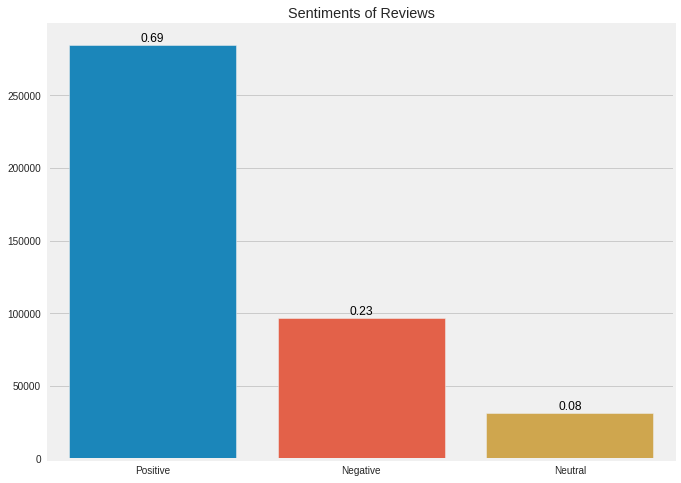

In [6]:
# Dropa os valores em nulos da variável "Reviews"
reviews.dropna(subset=['Reviews'], inplace=True)

# Cria o novográfico de barras da variável Sentiment
plt.figure(figsize=(10,8))
ax = sns.barplot(x=reviews['Sentiment'].value_counts().index, 
                 y=reviews['Sentiment'].value_counts().values, 
                 data=reviews)

total = float(len(reviews))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Sentiments of Reviews')
plt.show()

Vamos Agora examinar as marcas de celulares vendidos `Brand Name` para tirar mais alguns insghts sobre o dataset. De inicio vamos olhar uma tabela cruzada das contagens e ver a frequência das marcas que mais foram vendidas e alguns demais produtos.

In [7]:
# Visualizando a tabela de frequência das marcas
brands = pd.crosstab(index=reviews['Brand Name'], columns='Count')

brands

col_0,Count
Brand Name,
AKUA,4
AMM Global Enterprises,9
ARGOM TECH,2
ASUS,483
ASUS Computers,719
...,...
star,29
the Nokia,12
verykool,1156


In [8]:
# Marcas mais de celulares mais vendidas
brands.sort_values(by='Count', ascending=False).head(10)

col_0,Count
Brand Name,
Samsung,65728
BLU,63246
Apple,58179
LG,22410
BlackBerry,16872
Nokia,16805
Motorola,13417
HTC,12724
CNPGD,12613


No dataset existem 384 produtos diferentes porém parece que nem todos são aparelhos smartphones, **existem diversos outros tipos de produtos relacionados a celulares** como capinhas de celulares, smart watchs dentre outros. 

Além do mais parece que algumas marcas de produtos estão com nomes errados dentro do dataset, o correto a se fazer seria uma investigação mais longa e arrumar todos os produtos corretamente, porém este não e o objetivo deste projeto, vamos nos focar apenas no texto relativo aos reviews, mas por enquanto vamos dar continuidade a análise exploratória dos dados, vendo alguns produto que não são celulares, presentes na base de dados.

In [9]:
cnpgd = reviews[reviews['Brand Name'] == 'CNPGD']

cnpgd.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
166404,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,4,Oh my! If you can get the install complete it ...,0.0,Positive
166405,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,5,great,1.0,Positive
166406,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,5,This watch is amazing. Technology can't get be...,0.0,Positive
166407,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,3,I love the watch/phone and everything it offer...,0.0,Neutral
166408,CNPGD [U.S. Office Extended Warranty] Smartwat...,CNPGD,49.99,3,Pretty good watch.,0.0,Neutral


In [10]:
cnpgd['Price'].describe()

count    12613.000000
mean        52.007997
std         13.697218
min         29.990000
25%         49.990000
50%         49.990000
75%         59.990000
max         99.990000
Name: Price, dtype: float64

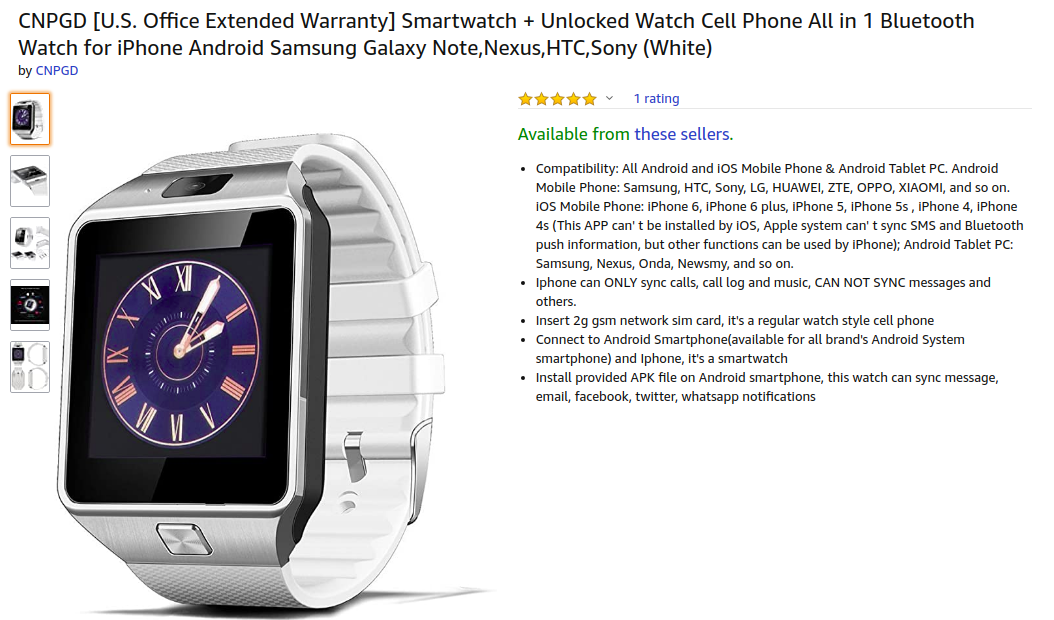

In [11]:
from IPython.display import Image
Image('CNPGD.png')

In [12]:
otterbox = reviews[reviews['Brand Name'] == 'OtterBox']

otterbox.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
289,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,5,"We buy these for work, good price and would be...",0.0,Positive
290,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,5,They are wonderful. got them for my son as he ...,0.0,Positive
291,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,3,Does the job but just barely,0.0,Neutral
292,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,5,lasting longer than the oem,0.0,Positive
293,3 Pack Replacement Belt Clip Holster for Otter...,OtterBox,17.95,5,Crear product. Fast arrived.,0.0,Positive


In [13]:
otterbox['Price'].describe()

count    7987.000000
mean       18.999176
std        12.053754
min         1.730000
25%         9.990000
50%        16.900000
75%        27.490000
max        59.950000
Name: Price, dtype: float64

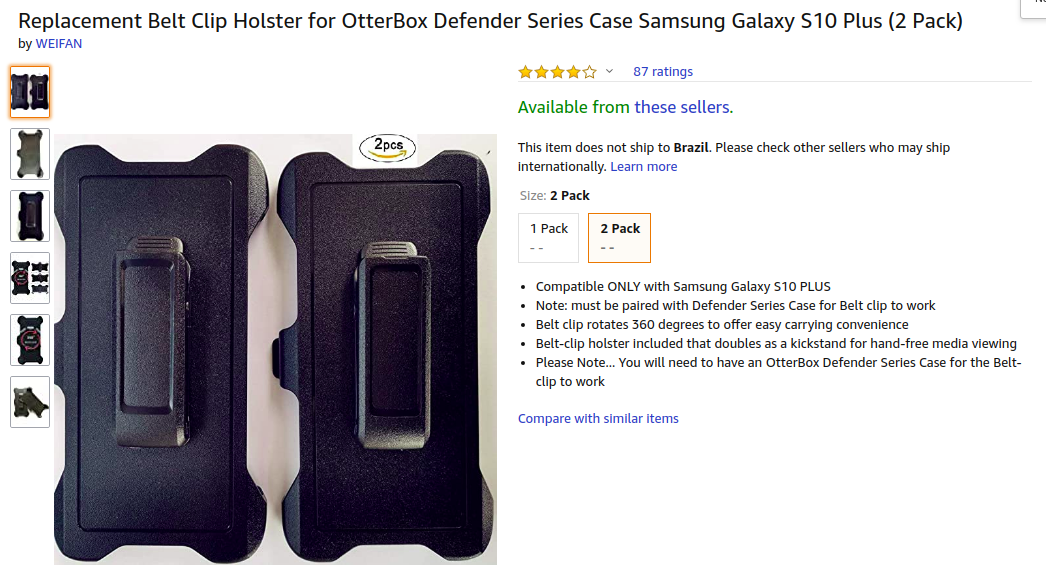

In [14]:
Image('OtterBox.png')

Agora que foi feita uma exploração na variável `Brand Name` vamos examinar a variável quantitativa `Price`, vamos examina-la a fim de encontrar mais alguns insights. Primeiro vamos ver sua distribuição, como base em cada um dos três sentimentos.

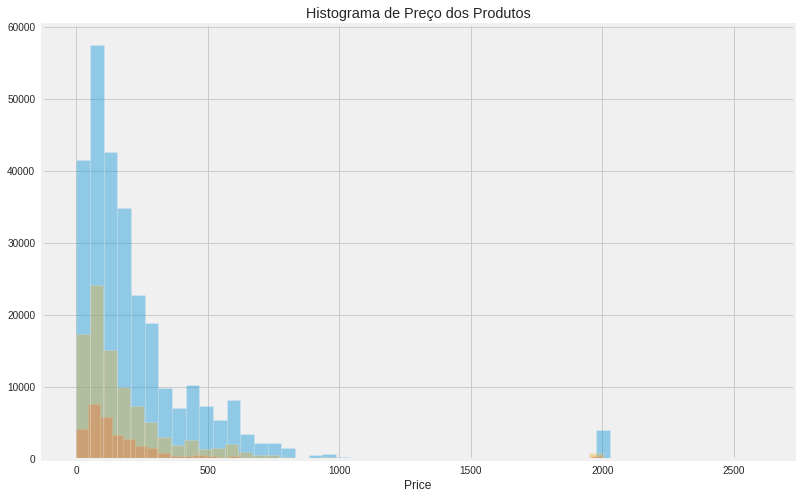

In [15]:
# Exclui os valores nulos da variável "Price"
reviews_price = reviews.dropna(subset=['Price'])

# Define o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Histograma da variável "Preço" com base nos clientes que tiveram sentimentos positivos
positive_price = reviews_price[reviews_price['Sentiment'] == 'Positive']
sns.distplot(positive_price['Price'], hist=True, kde=False, label='Positive')

# Histograma da variável "Preço" com base nos clientes que tiveram sentimentos Neutros
neutral_price = reviews_price[reviews_price['Sentiment'] == 'Neutral']
sns.distplot(neutral_price['Price'], hist=True, kde=False, label='Neutral')

# Histograma da variável "Preço" com base nos clientes que tiveram sentimentos Negativos
negative_price = reviews_price[reviews_price['Sentiment'] == 'Negative']
sns.distplot(negative_price['Price'], hist=True, kde=False, label='Negative')

# Plota o histograma
plt.title('Histograma de Preço dos Produtos')
plt.show()

In [16]:
reviews_price.groupby('Sentiment')['Price'].mean()

Sentiment
Negative    200.148108
Neutral     185.627763
Positive    240.465474
Name: Price, dtype: float64

Ambos os sentimentos tem a mesma distribuição e seus histogramas são muito semlhantes, isso nos faz pensar a respeito se a média dos clientes que tiveram sentimentos diferentes são iguais. Mais será que somente as médias aprensentadas anteriormente são necessárias para afirmar que produtos com um preço mais alto possui sentimentos mais polarizados? 

Para checar se isso é verdade podemos realizar uma **ANOVA** para poder testar se o sentimento tende a ficar mais polarizado a medida que a média de preço do produto aumenta. O lado bom de realizar uma ANOVA é que além de levar em consideração a médida do produto ela considera também a a variação dentro de cada tipo de sentimento.

Antes de realizar o teste, vamos plotar um box-plot de cada sentimento e seu preço para poder ver a variação de cada um e também visualizar possíveis outliers

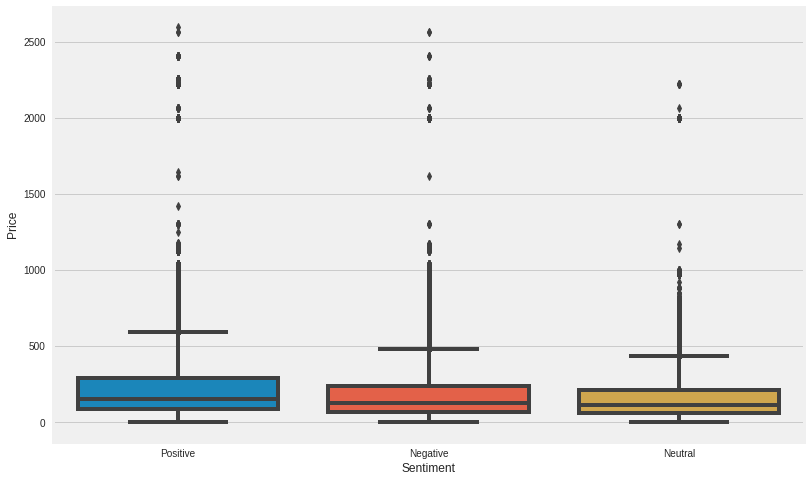

In [17]:
# Definindo o tamanho do gráfico
plt.figure(figsize=(12,8))

# Box-Plot do Preço em relação aos sentimentos
sns.boxplot(x='Sentiment', y='Price', data=reviews_price)

# Plota o gráfico
plt.show()

Com o box-plot também podemos exergar a distribuição da variável preço para cada sentimento. Com ele podemos ver que há muito outliers em ambos os sentimentos e a mediana de cada sentimento estão muito próximas. Agora vamos então realizar a ANOVA.

In [18]:
# Cria uma variável categorica para se realizar o teste
reviews_price['Sentiment_ord'] = pd.Categorical(reviews_price.Sentiment)

# ANOVA para os Sentimentos
reviews_price.anova(dv='Price', between='Sentiment_ord', detailed=True).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,Sentiment_ord,1.730022e+08,2,8.650112e+07,1167.11,0,0.006
1,Within,3.022776e+10,407845,7.411580e+04,-,-,-


Agora vamos realizar uma interpretação dos resultados obitidos do teste. **O valor P obtido da análise ANOVA é significativo (P <0,05)** e, portanto, concluímos que existem diferenças significativas entre as médias dos preços para cada sentimento.

A partir da ANOVA, sabemos que as médias entre de preço em relação a cada sentimento são estatisticamente significativas, mas a ANOVA não informa quais dos sentimentos são significativamente diferentes entre si. Para descobris isso, realizaremos análises de comparação múltipla por pares **(comparação post-hoc) usando o teste Tukey HSD**.

In [19]:
# Executa a comparação pareada múltipla (Tukey HSD)
reviews_price.pairwise_tukey(dv='Price', between='Sentiment_ord')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,Negative,Neutral,200.148,185.628,14.520,1.777,two-sided,8.172,0.001,0.053
1,Negative,Positive,200.148,240.465,-40.317,1.021,two-sided,-39.495,0.001,-0.148
2,Neutral,Positive,185.628,240.465,-54.838,1.625,two-sided,-33.742,0.001,-0.201


Os resultados acima do Tukey HSD sugerem que, todas as outras comparações pareadas para sentimentos rejeitam a hipótese nula e indicam diferenças estatísticas significativas, isto pode ser visto pela coluna **"diff"** dos resultados que é difereção as médias de cada sentimento.

Agora que realizamos os teste e provamos que há diferenças entre as médias para cada tipo de sentimento, vamos passar agora para a parte de **text mining**. Vamos realizar uma análise bem detalhada na variável `Reviews` e também aplicar o pré-processamento para que possamos poder utilizar alguns algoritimos de machine learning na mesma.

De inicio vamos dropar todas as linhas que possuem valores **Neutral** do dataset para que podessamos transformar este um trabalho de **classificação binária** e depois vamos ver como ficou a proporção de sentimentos "Positive" e "Negative" após o drop dos sentimentos "Neutral".

In [20]:
# Dropa as linhas que possuem sentimentos neutros
reviews = reviews.drop(reviews[reviews['Sentiment'] == 'Neutral'].index)

# Proporção do dataset
pd.crosstab(index=reviews['Sentiment'], columns='Count')

col_0,Count
Sentiment,
Negative,97061
Positive,284954


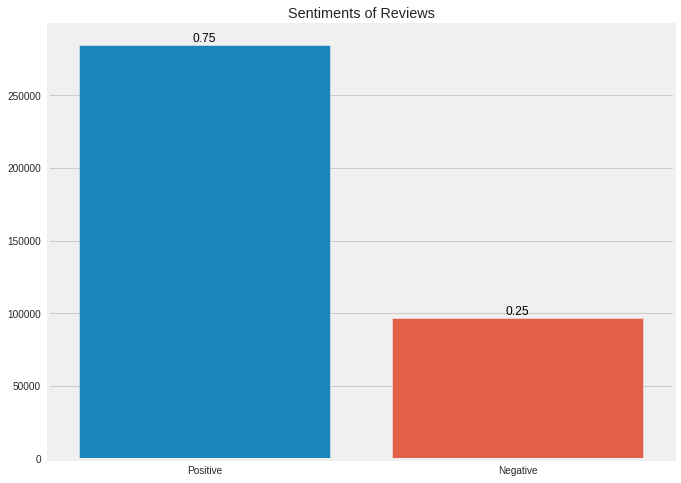

In [21]:
# Cria o novog ráfico de barras da variável Sentiment
plt.figure(figsize=(10,8))
ax = sns.barplot(x=reviews['Sentiment'].value_counts().index, 
                 y=reviews['Sentiment'].value_counts().values, 
                 data=reviews)

total = float(len(reviews))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Sentiments of Reviews')
plt.show()

Agora vamos começar vendo algumas informações basicas sobre o texto dos reviews sobre os produto, vamos começar com **medidas estatisticas básicas além de algumas contagens de palvras** ao longo desta parte do projeto, para isto vamos utilizar a biblioteca **nltk**, pois a mesma já possui tais funções integradas.

In [22]:
# Média de caracteres em reviews com diferentes sentimentos
positive_carct = reviews[reviews['Sentiment'] == 'Positive']['Reviews'].apply(len)
negative_carct = reviews[reviews['Sentiment'] == 'Negative']['Reviews'].apply(len)

# Média de caracteres númericos em reviews com diferentes sentimentos
positive_dig = reviews[reviews['Sentiment'] == 'Positive']['Reviews'].str.count('(\d)')
negative_dig = reviews[reviews['Sentiment'] == 'Negative']['Reviews'].str.count('(\d)')

# Média de caracteres que não são palavras em reviews com diferentes sentimentos
positive_punct = reviews[reviews['Sentiment'] == 'Positive']['Reviews'].str.count('(\W)')
negative_punct = reviews[reviews['Sentiment'] == 'Negative']['Reviews'].str.count('(\W)')

print('__________________________________________________________________________________________________')
print('Quantidade média de caracteres em reviews com sentimentos positivos: ', 
      np.mean(positive_carct))
print('Quantidade media de caracteres em reviews com sentimentos negativos: ', 
      np.mean(negative_carct))
print('__________________________________________________________________________________________________')
print('Quantidade media de caracteres númericos em reviews com sentimentos positivos: ', 
      np.mean(positive_dig))
print('Quantidade media de caracteres númericos em reviews com sentimentos negativos: ', 
      np.mean(negative_dig))
print('__________________________________________________________________________________________________')
print('Quantidade media de caracteres que não são palavras em reviews com sentimentos positivos: ', 
      np.mean(positive_punct))
print('Quantidade media de caracteres que não são palavras em reviews com sentimentos negativos: ', 
      np.mean(negative_punct))

__________________________________________________________________________________________________
Quantidade média de caracteres em reviews com sentimentos positivos:  191.3782645619995
Quantidade media de caracteres em reviews com sentimentos negativos:  264.62001215730317
__________________________________________________________________________________________________
Quantidade media de caracteres númericos em reviews com sentimentos positivos:  1.1694624395516469
Quantidade media de caracteres númericos em reviews com sentimentos negativos:  1.5267512183060137
__________________________________________________________________________________________________
Quantidade media de caracteres que não são palavras em reviews com sentimentos positivos:  40.665689900826095
Quantidade media de caracteres que não são palavras em reviews com sentimentos negativos:  56.54871678635085


Apenas com a média e possivel tirar alguns insights interessantes a respeito do texto presente nos reviews. Podemos ver que em média produtos com reviews negativos possuem mais caracteres **264.62** do que os reviews positivos que posuem uma média de **191.37**. Referente a caracteres númericos as médias tanto de reviews positivos quanto negativos são muito próximas, sendo os positivos possuem **1.16** e os negativos **1.52**. Já referentes a caracteres que não são nem númericos nem letras como (ex: , . ? !) os reviews positivos possuem menos que os negativos sendo em média **40.66** caracteres para reviews positivos contra, **56.54** para reviews positivos.

Agora vamos realizar toda a limpeza do texto de todos os reviews de compra de produtos presentes no dataset. Para isso vamos criar uma classe com funções para fazer toda a limpeza necessária no texto, começando **transformando todas as sentenças para caixa baixa**, **removendo digitos**, **removendo a pontuação** e removendo as ***stopwords*** que são palavras que costumam a se repitir muitas vezes que possuem pouco significado pragmático em relação a tipo de sentimento de cada review. 

Logo em seguida é aplicado o ***Stemming*** nos reviews que nada mais é do que o algoritmo técnica para limpar dados de texto para processamento. No Stemming é utilizado para remoção de préfixos e sufixos das palavras de cada review, tal técnica acaba por melhorar a performace dos modelos de análise textual.

In [23]:
# Cria a classe com todos os procedimentos de limpeza necessários para os reviews
class CleanReview(BaseEstimator, TransformerMixin):
    
    # Converte texto em letras minúsculas
    def to_lower(self, reviews_text):
        return reviews_text.lower()
    
    # Remove a pontuação
    def remove_dig(self, reviews_text):
        return re.sub('\d+', '', reviews_text)
    
    # Remove a pontuação
    def remove_punct(self, reviews_text):
        # Cria uma tabela de tradução
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Todo simbolo da pontuação e substituido por um espaço
        return reviews_text.translate(trantab)
    
    # Remove as stopwords em português
    def remove_stopwords(self, reviews_text):
        stopwords_list = nltk.corpus.stopwords.words('english')
        words = reviews_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1] 
        return " ".join(clean_words)     
    
    # Aplica o RSLPStemming que é o PorterStemming específico para a lingua portuguesa
    def stemming(self, reviews_text):
        stem = nltk.stem.SnowballStemmer('english')
        words = reviews_text.split() 
        stemmed_words = [stem.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    # Define o treinamento
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean = X.apply(
            self.to_lower).apply(
            self.remove_dig).apply(
            self.remove_punct).apply(
            self.remove_stopwords).apply(
            self.stemming)
        return clean

In [24]:
cr = CleanReview()
reviews_clean = cr.fit_transform(reviews['Reviews'])
reviews_clean = pd.DataFrame(reviews_clean)
reviews_clean.head()

,Reviews
0,feel lucki found use phone us use hard phone l...
1,nice phone nice grade pantach revu clean set e...
2,pleas
3,work good goe slow sometim good phone love
4,great phone replac lost phone thing volum butt...


Agora com a limpeza dos texto toda realizada vamos dar continuidade a nossa análise, visualizando as palavras que mais foram utilizadas nos reviews dos produtos, tanto nos sentimentos positivos, tanto nos negativos.

Para isso vamos utilizar uma nuvem de palavras para poder ver quais fora as mais utilizadas, mas primeiro vamos deixar o dataset já pronto para análises posteriores, fazendo o encoding dos sentimentos e assim reorganizando o novo dataset para uso.

In [25]:
# Mapeando os Sentimentos e fazendo o encoding da variável alvo
reviews_clean['Encod_Sentiment'] = reviews['Sentiment'].map({'Negative': 0, 'Positive': 1})

# Checando o novo atributo
reviews_clean['Encod_Sentiment'].value_counts()

1    284954
0     97061
Name: Encod_Sentiment, dtype: int64

In [26]:
# Filtrando reviews com sentimentos positivos
positive_words = reviews_clean[reviews_clean['Encod_Sentiment'] == 1]

# Filtrando reviews com sentimentos negativos
negative_words = reviews_clean[reviews_clean['Encod_Sentiment'] == 0]

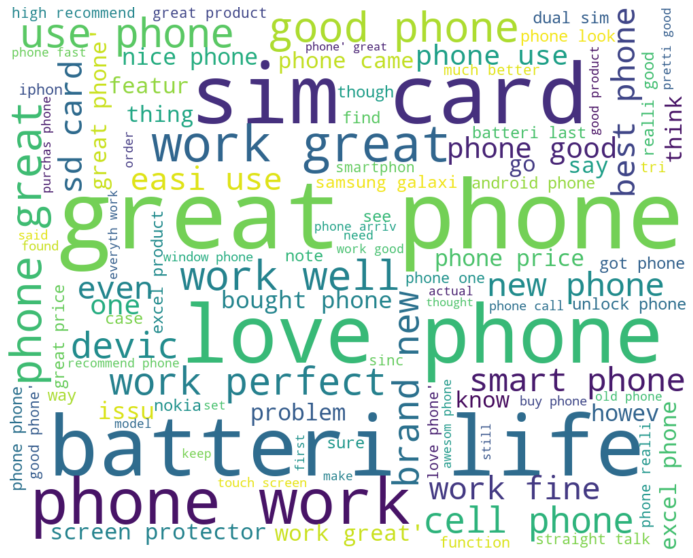

In [27]:
# Cria uma lista vazia
words = []

# Realiza um loop iterando pelos reviews e adicionando a lista vazia "words"
for i in positive_words.Reviews:
    words.append(i)

# Passa os reviews para o formato str
words = str(words)

# Cria a wordcloud dos reviews com sentimentos positivos
wordcloud = WordCloud(max_words=100, 
                      width=1000, 
                      height=800, 
                      margin=0, 
                      background_color='white').generate(words)

# Plota o gráfico
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

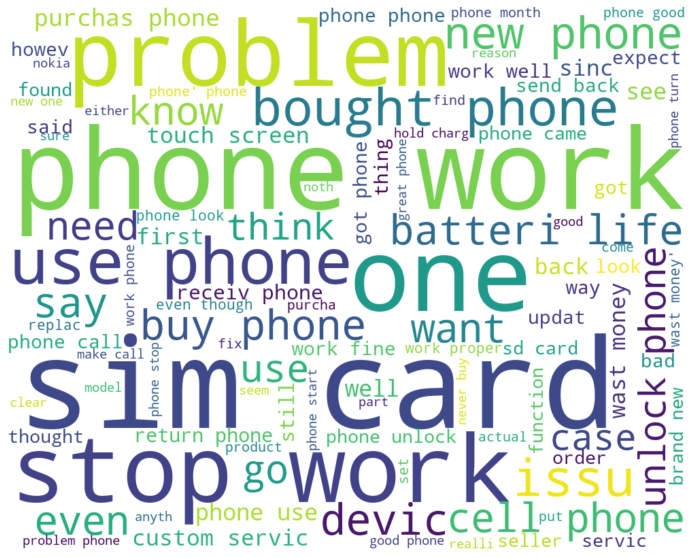

In [28]:
# Cria uma lista vazia
words = []

# Realiza um loop iterando pelos reviews e adicionando a lista vazia "words"
for i in negative_words.Reviews:
    words.append(i)

# Passa os reviews para o formato str
words = str(words)

# Cria a wordcloud dos reviews com sentimentos negativos
wordcloud = WordCloud(max_words=100, 
                      width=1000, 
                      height=800, 
                      margin=0, 
                      background_color='white').generate(words)

# Plota o gráfico
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

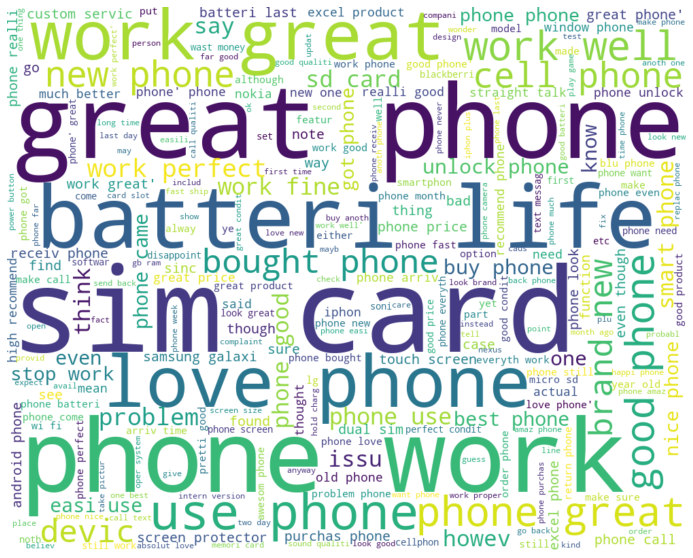

In [29]:
# Cria uma lista vazia
words = []

# Realiza um loop iterando pelos reviews e adicionando a lista vazia "words"
for i in reviews_clean.Reviews:
    words.append(i)

# Passa os reviews para o formato str
words = str(words)

# Cria a wordcloud dos reviews de todos os sentimentos
wordcloud = WordCloud(max_words=250, 
                      width=1000, 
                      height=800, 
                      margin=0, 
                      background_color='white').generate(words)

# Plota o gráfico
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Agora vamos para a construção dos modelos, para criação dos modelos vamos utilizar duas técnicas diferentes e a partir delas escolher o modelo com melhor perfomace para classificação dos reviews do app do banco. 

Primeiro vamos criar os modelos com o ***CountVectorizer*** que converte uma coleção de documentos de texto em uma matriz de contagens de tokens e depois com o ***TfidfVectorizer*** que converte uma coleção de documentos brutos em uma matriz de recursos TF-IDF.

Mas primeiro vamos pegar o dataset fazer duas copias, uma faremos uma transformação com CountVectorizer e a outra faremos uma trasnformação TfidfVectorizer. Em seguida vamos plotar as distribuições de frequências de tokens de ambas as transformações para que possamos compará-las.

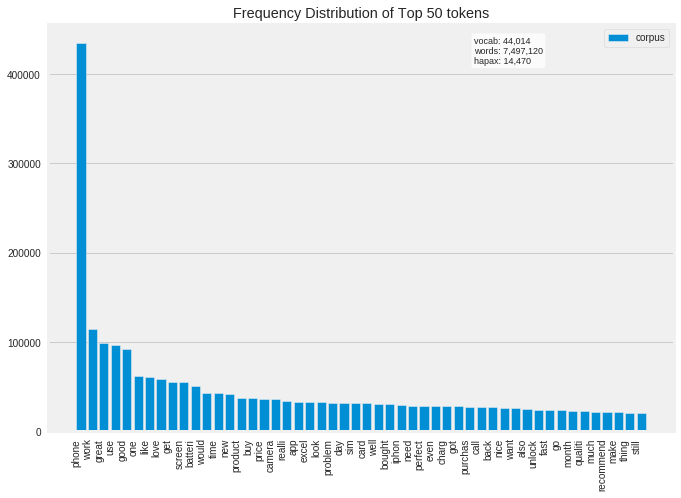

In [30]:
# Instancia o Count Vectorizer
vectorizer = CountVectorizer()

# Realiza do treinamento
reviews_cvect = vectorizer.fit_transform(reviews_clean.Reviews)

# Obtém os nomes das features
features = vectorizer.get_feature_names()

# Plota o gráfico da distribuição de frequência dos tokens
viz = FreqDistVisualizer(features=features, orient='v', size=(720, 540))
viz.fit(reviews_cvect)
viz.show()

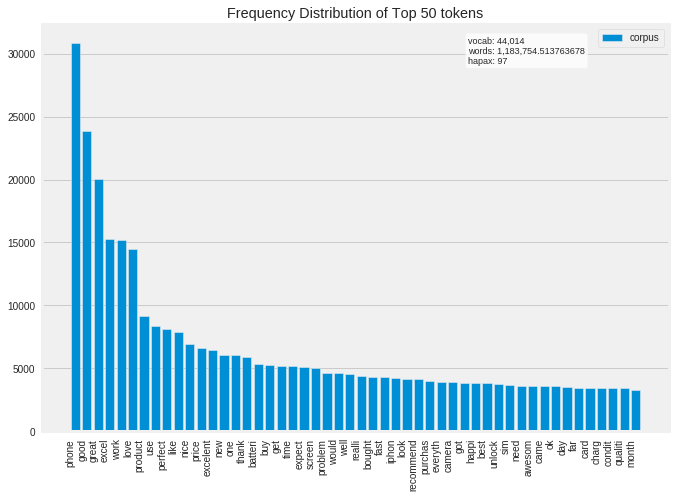

In [31]:
# Instancia o TF-IDF
vectorizer = TfidfVectorizer()

# Realiza do treinamento
reviews_tfidf = vectorizer.fit_transform(reviews_clean.Reviews)

# Obtém os nomes das features
features = vectorizer.get_feature_names()

# Plota o gráfico da distribuição de frequência dos tokens
viz = FreqDistVisualizer(features=features, orient='v', size=(720, 540))
viz.fit(reviews_tfidf)
viz.show()

Vemos que assim como as wordclouds a distribuição de frequência de ambas as transformações apresentam as mesmas palavras, sendo **"phone"** a que tende mais a aparecer ao longo dos reviews.

Podemos prosseguir agora para a criação dos modelos de **machine leanrning** para tetar prever os sentimentos dos reviews, antes de iniciar vamos dividir o conjunto de dados em **treino e teste**.

Para que possamos comparar qual técnica se sai melhor no conjunto de dados vamos realizar duas divisões de treino e teste, uma usando os dados com **CountVectorizer** e outra com **TfidfVectorizer** em seguida vamos realizar o treinamento de vários modelos a fim de compara-lós para poder escolher o melhor.

In [32]:
# Dividi o conjunto de em treino e teste com base no CountVectorizer
X_train_cvect, X_test_cvect, y_train_cvect, y_test_cvect = train_test_split(reviews_cvect, 
                                                                            reviews_clean['Encod_Sentiment'], 
                                                                            random_state=42)

Logistic Regression: 0.968549 (0.001460)
SGD Classifier: 0.961162 (0.002047)
Decision Tree Classifier: 0.928526 (0.001854)
Multinomial Naive Bayes: 0.949416 (0.000899)
Bernoulli Naive Bayes: 0.907591 (0.001128)


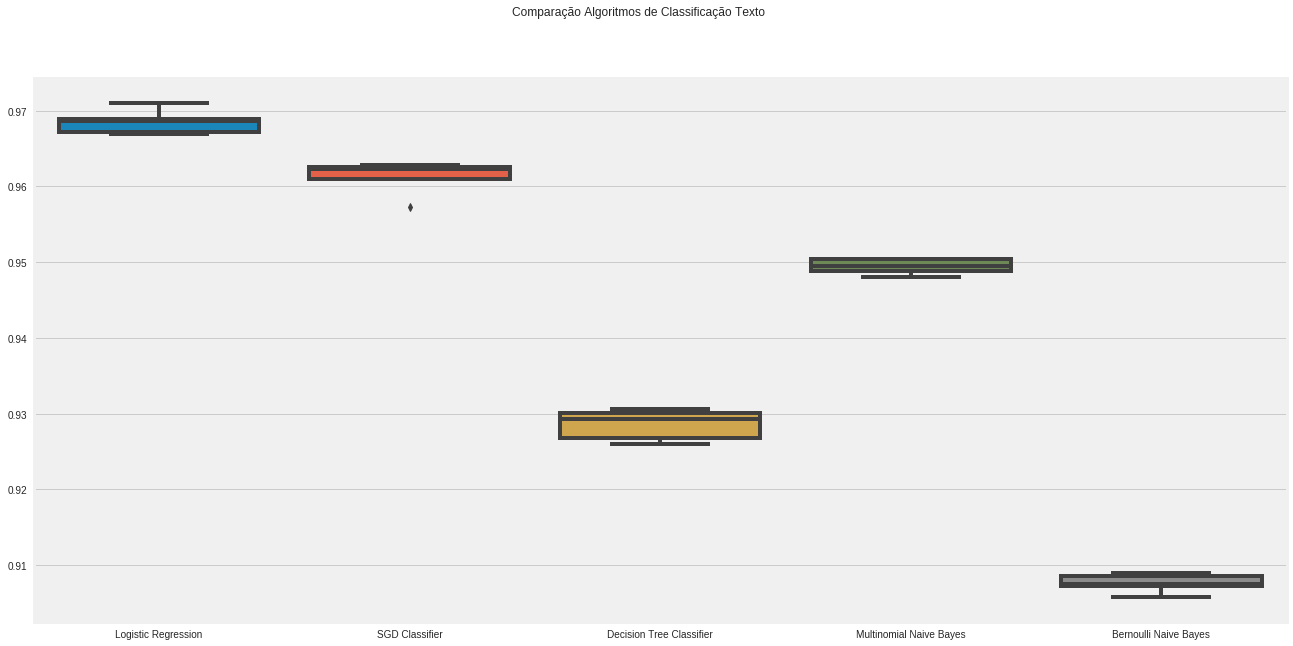

In [33]:
# Instanciando e criando uma lista com os modelos
modelos = []
modelos.append(('Logistic Regression', LogisticRegression(random_state=42)))
modelos.append(('SGD Classifier', SGDClassifier(random_state=42)))
modelos.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)))
modelos.append(('Multinomial Naive Bayes', MultinomialNB()))
modelos.append(('Bernoulli Naive Bayes', BernoulliNB()))

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor modelo por meio de uma validação cruzada
for nome, modelo in modelos:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(modelo, X_train_cvect, y_train_cvect, cv=kfold, scoring='roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot para comparação entre os modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Classificação Texto')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.show()

Segundo o box-plot anterior o modelo que melhor performou com os dados utilizando o **CountVectorizer** foi a **Regressão Logística** isso com base no seu **ROCAUC score de 96,85%**.

A **Regressão logística** estima valores discretos (como no nosso caso **Positivo** e **Negativo**) com base em um determinado conjunto de variáveis independentes. Simplificando, ele basicamente prevê a probabilidade de ocorrência de um evento ajustando dados a uma função de logit. Por isso, também é conhecido como regressão logit. Os valores obtidos sempre estariam dentro de 0 e 1, pois prevê a probabilidade.

Com base nisso vamos escolher o mesmo e ajusta-lo utilizando o **GridSearchCV**. A pesquisa em grade (*GridSearchCV*) é uma maneira de ajustar varios hiperparâmetros de um modelo um por um até que ele encontre uma combinação que retorne a maior métrica selecionada possível (neste caso ROCAUC score).

In [34]:
# Definindo a Regressão Logística
logistic_reg = LogisticRegression()

# Definindo os melhores parâmetros a serem utilizados
params = grid_params = {'penalty': ['l2'],
                        'C': [0.001,0.01,0.1,1,10,100], 
                        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                        'random_state': [42]}

# Instancia o Grid Search CV
gsearch_cv = GridSearchCV(estimator=logistic_reg, 
                          param_grid=params, 
                          cv=5, 
                          scoring='roc_auc',
                          n_jobs=-1)

# Treinando o modelo
gsearch_cv.fit(X_train_cvect, y_train_cvect)

# Parâmetros que retornando a melhor roc_auc
print('Grid best parameter (max. ROC AUC Score):', gsearch_cv.best_params_)

# Score do modelo
print('Best ROC AUC: ', gsearch_cv.best_score_)

Grid best parameter (max. ROC AUC Score): {'C': 10, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg'}
Best ROC AUC:  0.9711078334093713


Com base numa série de parâmetros definidos e passados a função *GridSearchCV* ela nos os oarâmetros que geram o maior ROCAUC score no caso de **97,11**. Sendo eles:

**C: 10** Que é o inverso da força de regularização;

**Penalty: l2** Usado para especificar a norma **Ridge** na penalização;

**solver: newton-cg** Algoritmo a ser usado no problema de otimização;

Agora com os parâmetros ideias encontrados vamos treinar o modelo e realizar uma **validação cruzada** para descobrir se nossos dados estão generalizando nos conjunto de treinamento e teste. Para realizar a validação cruzada, vamos utilizar a função **cross_val_score** do Scikit Learn.

In [35]:
# Instancia o modelo Logistic Regression
logistic_reg = LogisticRegression(C=10, 
                                  penalty='l2',
                                  solver='newton-cg',
                                  random_state=42)

# Treinando o modelo e aplicando o Cross Validation
logistic_reg.fit(X_train_cvect, y_train_cvect)
pred = logistic_reg.predict(X_test_cvect)
logreg_cv = cross_val_score(logistic_reg, X_train_cvect, y_train_cvect, cv=5, scoring='roc_auc')
logreg_cv

array([0.97064312, 0.97089121, 0.9722333 , 0.97151115, 0.97026039])

Ótimo o modelo se ajustou muito bem tanto ao conjunto de treino quanto ao conjunto de teste. Agora vamos realizar a avalização final deste primeiro modelo criado por meio das métricas de **Matriz de Confusão**, **Curva ROC** e **Precisão e Revocação**. Para isso será utilizado a biblioteca YellowBrick que possui todas essas métricas já pronta para uso e uma estética muito agradável.

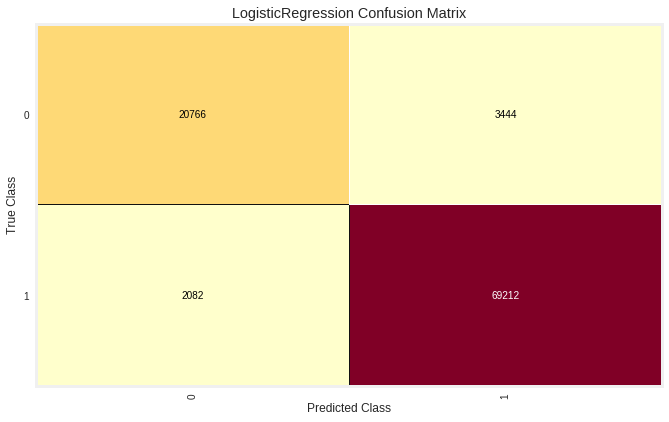

In [36]:
# Apresentando o modelo para ConfusionMatrix
cm = ConfusionMatrix(logistic_reg, classes=[0,1], size=(720, 480))

# Treina o modelo
cm.fit(X_train_cvect, y_train_cvect)

# Apresentando os dados de teste para a ConfusionMatrix
cm.score(X_test_cvect, y_test_cvect)

# Plot a Matriz de Confusão
cm.show()

O gráfico assim dos da a matriz de confusão para o modelo de regressão logística, o mesmo teve para os dados de teste:
    
**True Positive: 69212**

**False Positive: 3444**

**True Negative: 20766**

**False Negative: 2082**

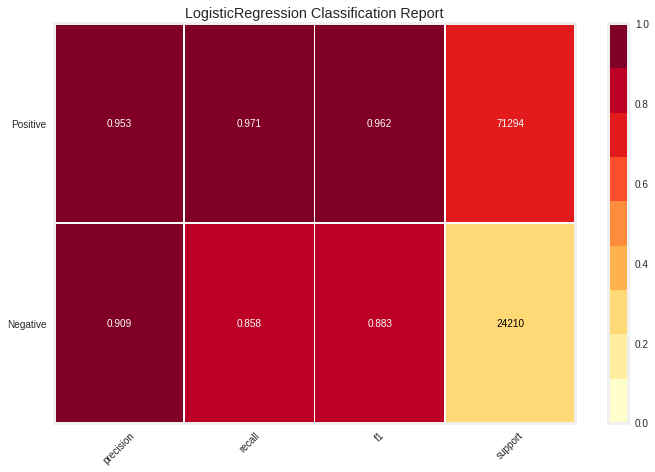

In [37]:
# Classes utilizadas pelo modelo
classes = ["Negative", "Positive"]

# Apresentando o modelo para ConfusionMatrix
viz = ClassificationReport(logistic_reg, classes=classes, support=True, size=(720, 480))

# Treina o modelo
viz.fit(X_train_cvect, y_train_cvect)

# Apresentando os dados de teste para a ClassificationReport
viz.score(X_test_cvect, y_test_cvect)

# Plota o Relatório de classificação
viz.show()

O gráfico anterior mostra o um resumo das metricas de classificação **Precision**, **Recall** e **F1 Score** para os dados de teste. Sendo que quanto mais escura a cor for melhor é a métrica para cada categoria prevista, no caso se o review é positivo ou negativo.

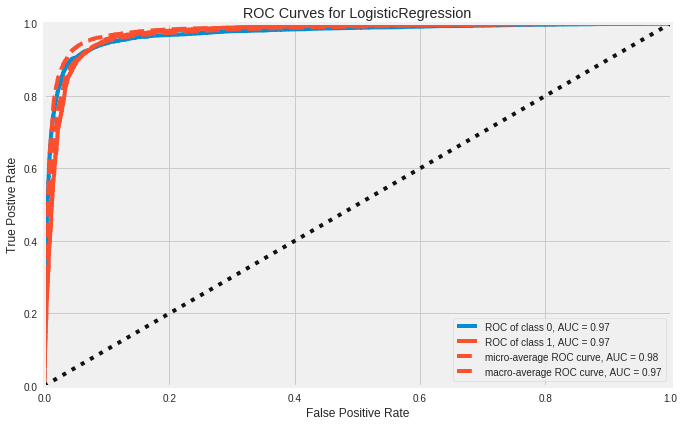

In [38]:
# Instanciando a curva ROCAUC
viz = ROCAUC(logistic_reg, size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
viz.fit(X_train_cvect, y_train_cvect)

# Avalie o modelo nos dados de teste
viz.score(X_test_cvect, y_test_cvect)

# Plota da curva ROCAUC
viz.show()

A curva **ROC** mostra que quão bom o modelo criado pode distinguir entre as duas polaridades de sentimento positivo e negativo, ou seja, uma curva ROC traça a **taxa de True Positive vs. a taxa de False Positive”**.

Já a **AUC** (área sob a curva) nada mais é que uma maneira de resumir a curva ROC em um único valor, agregando todos os limiares da ROC, calculando a “área sob a curva”. No caso deste primeiro modelo teve uma **AUC muito elevada 0.97 para ambas as classes**. 

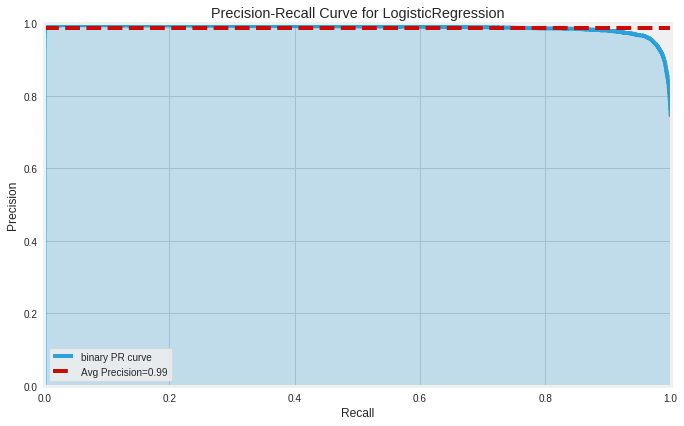

In [39]:
# Instanciando a curva de Precisão-Revocação
viz = PrecisionRecallCurve(logistic_reg, size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
viz.fit(X_train_cvect, y_train_cvect)

# Avalie o modelo nos dados de teste
viz.score(X_test_cvect, y_test_cvect)

# Plota da curva Precisão-Revocação
viz.show()

A **Precision-Recall curve** resumem o trade-off entre a True Positive e o valor preditivo positivo para um modelo preditivo usando diferentes limites de probabilidade. No caso do primeiro modelo teve uma curva **uma precisão de 0.99**

Agora vamos para segunda parte onde relizamos a divisão em treino e teste com base no **TfidfVectorizer** e então treinamos os 5 mesmos algoritmos para decidir qual modelo utilizar.

In [40]:
# Dividi o conjunto de treinamento em treino e teste com base no TfidfVectorizer
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(reviews_tfidf, 
                                                                            reviews_clean['Encod_Sentiment'], 
                                                                            random_state=42)

Logistic Regression: 0.974404 (0.000543)
SGD Classifier: 0.967353 (0.000572)
Decision Tree Classifier: 0.926706 (0.002754)
Multinomial Naive Bayes: 0.965794 (0.000560)
Bernoulli Naive Bayes: 0.907591 (0.001128)


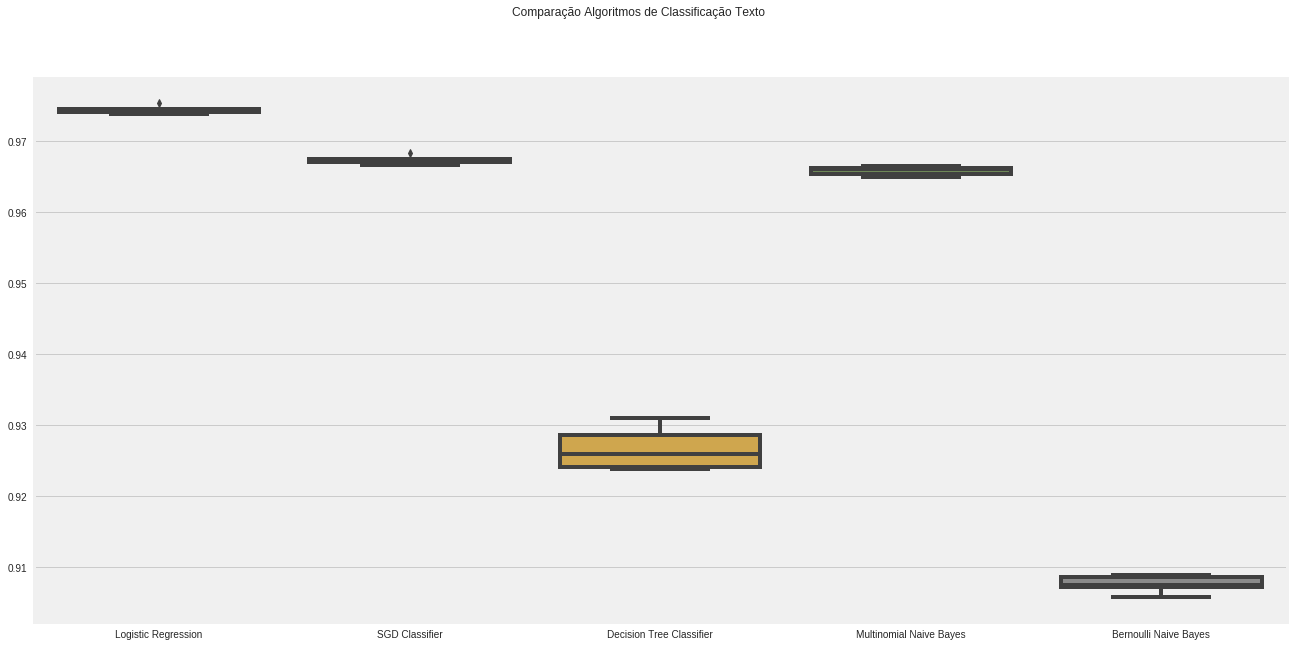

In [41]:
# Instanciando e criando uma lista com os modelos
modelos = []
modelos.append(('Logistic Regression', LogisticRegression(random_state=42)))
modelos.append(('SGD Classifier', SGDClassifier(random_state=42)))
modelos.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)))
modelos.append(('Multinomial Naive Bayes', MultinomialNB()))
modelos.append(('Bernoulli Naive Bayes', BernoulliNB()))

# Lista de resultados e nomes dos modelos
resultados = []
nomes = []

# Seleção do melhor modelo por meio de uma validação cruzada
for nome, modelo in modelos:
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(modelo, X_train_tfidf, y_train_tfidf, cv=kfold, scoring='roc_auc')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Box-plot para comparação entre os modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação Algoritmos de Classificação Texto')
ax = fig.add_subplot(111)
sns.boxplot(x=nomes, y=resultados)
ax.set_xticklabels(nomes)
plt.show()

A **Regressão Logística** continua a ser o melhor algoritmo para esta base de dados até então. A Regressão Logítisca teve um desempenho de **97,44** sem qualquer tipo de ajuste ao modelo, cerca de 1 a mais do que o modelo que foi utilizado o **CountVectorizer**.

Agora que já possuimos uma veridito quanto ao modelo, da mesma forma como feito anteriormente vamos realizar uma pesquisa em grade *GridSearchCV* para descobrir as melhores combinações de hiperparâmetros para que possamos ter um melhor desempenho do que até então.

In [42]:
# Definindo a Regressão Logistica
logistic_reg = LogisticRegression()

# Definindo os melhores parâmetros a serem utilizados
params = grid_params = {'penalty': ['l2'],
                        'C': [0.001,0.01,0.1,1,10,100], 
                        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                        'random_state': [42]}

# Instancia o Grid Search CV
gsearch_cv = GridSearchCV(estimator=logistic_reg, 
                          param_grid=params, 
                          cv=5, 
                          scoring='roc_auc',
                          n_jobs=-1)

# Treinando o modelo
gsearch_cv.fit(X_train_tfidf, y_train_tfidf)

# Parâmetros que retornando a melhor roc_auc
print('Grid best parameter (max. ROC AUC Score):', gsearch_cv.best_params_)

# Score do modelo
print('Best ROC AUC: ', gsearch_cv.best_score_)

Grid best parameter (max. ROC AUC Score): {'C': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
Best ROC AUC:  0.9778781087729856


Com base numa série de parâmetros definidos e passados a função *GridSearchCV* ela nos retornou os seguintes parâmetros que geram o maior ROCAUC score no caso de **97,78**. Sendo eles:

**C: 100** Que é o inverso da força de regularização;

**Penalty: l2** Usado para especificar a norma **Ridge** na penalização;

**solver: saga** Algoritmo a ser usado no problema de otimização;

Agora com os parâmetros ideias encontrados vamos treinar o modelo e realizar uma **validação cruzada** para descobrir se nossos dados estão generalizando nos conjunto de treinamento e teste. Para realizar a validação cruzada, vamos utilizar a função **cross_val_score** do Scikit Learn.

In [43]:
# Instancia o modelo Logistic Regression
logistic_reg = LogisticRegression(C=100, 
                                  penalty='l2',
                                  solver='saga',
                                  random_state=42)

# Treinando o modelo e aplicando o Cross Validation
logistic_reg.fit(X_train_tfidf, y_train_tfidf)
pred = logistic_reg.predict(X_test_tfidf)
logreg_cv = cross_val_score(logistic_reg, X_train_tfidf, y_train_tfidf, cv=5, scoring='roc_auc')
logreg_cv

array([0.97721271, 0.97779539, 0.97864702, 0.9778673 , 0.97786814])

Assim como modelo anterior o modelo com **TfidfVectorizer** se ajustou muito bem tanto ao conjunto de treino quanto ao conjunto de teste. Agora vamos realizar a avalização final deste primeiro modelo criado por meio das métricas de **Matriz de Confusão**, **Curva ROC** e **Precisão e Revocação**. Para isso será utilizado a biblioteca YellowBrick que possui todas essas métricas já pronta para uso e uma estética muito agradável.

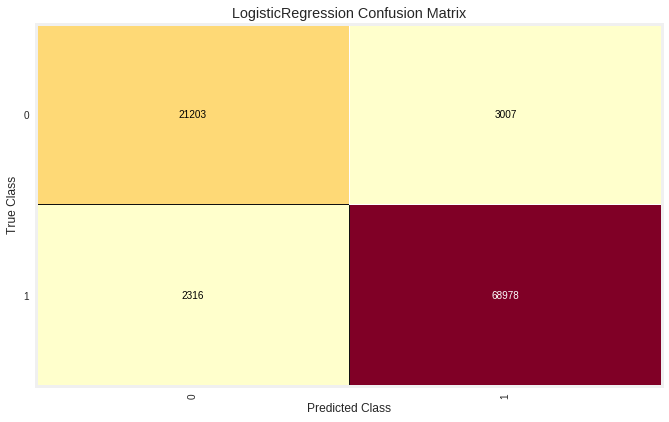

In [44]:
# Apresentando o modelo para ConfusionMatrix
cm = ConfusionMatrix(logistic_reg, classes=[0,1], size=(720, 480))

# Treina o modelo
cm.fit(X_train_tfidf, y_train_tfidf)

# Apresentando os dados de teste para a ConfusionMatrix
cm.score(X_test_tfidf, y_test_tfidf)

# Plot a Matriz de Confusão
cm.show()

O gráfico assim dos da a matriz de confusão para o modelo de regressão logística, o mesmo teve para os dados de teste:
    
**True Positive: 68978**

**False Positive: 3007**

**True Negative: 21203**

**False Negative: 2316**

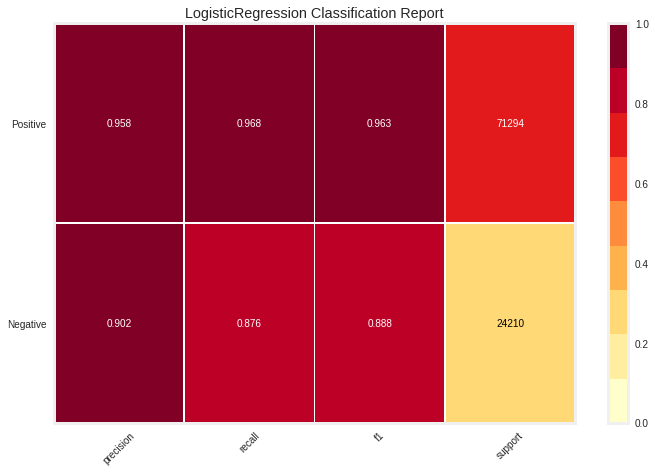

In [45]:
# Classes utilizadas pelo modelo
classes = ["Negative", "Positive"]

# Apresentando o modelo para ConfusionMatrix
viz = ClassificationReport(logistic_reg, classes=classes, support=True, size=(720, 480))

# Treina o modelo
viz.fit(X_train_tfidf, y_train_tfidf)

# Apresentando os dados de teste para a ClassificationReport
viz.score(X_test_tfidf, y_test_tfidf)

# Plota o Relatório de classificação
viz.show()

O gráfico anterior mostra o um resumo das metricas de classificação **Precision**, **Recall** e **F1 Score** para os dados de teste. Sendo que quanto mais escura a cor for melhor é a métrica para cada categoria prevista, no caso se o review é positivo ou negativo.

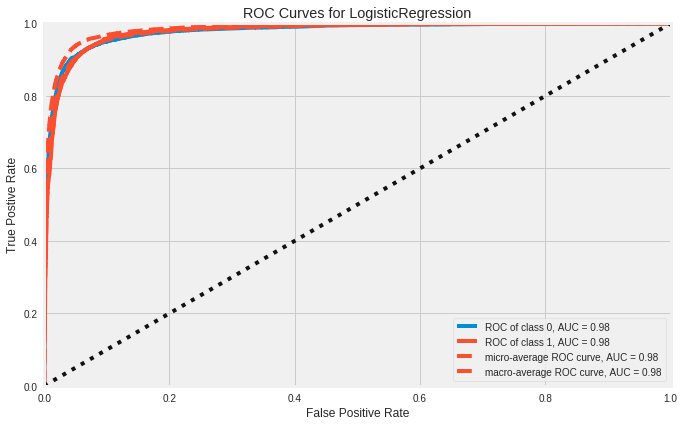

In [46]:
# Instanciando a curva ROCAUC
viz = ROCAUC(logistic_reg, size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
viz.fit(X_train_tfidf, y_train_tfidf)

# Avalie o modelo nos dados de teste
viz.score(X_test_tfidf, y_test_tfidf)

# Plota da curva ROCAUC
viz.show()

Como o seugndo modelo de regressão logística se saiu melhor do que o primeiro modelo teve uma era de se esperar que tivesse uma AUC mais elevada, para o modelo com **TF-IDF teve uma AUC de 0.98 para ambas as classes**. 

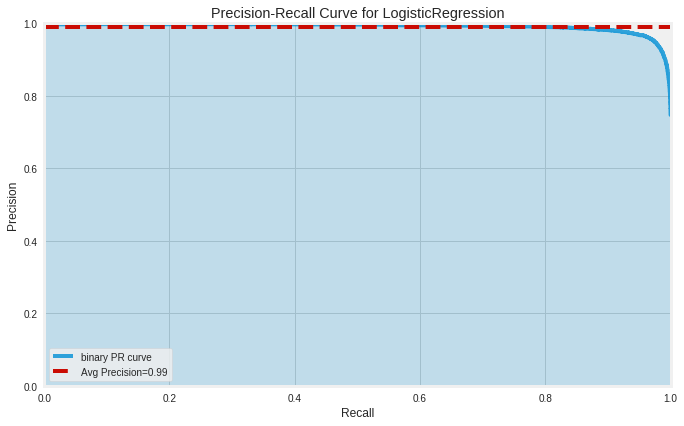

In [47]:
# Instanciando a curva de Precisão-Revocação
viz = PrecisionRecallCurve(logistic_reg, size=(720, 480))

# Ajuste os dados de treinamento ao visualizador
viz.fit(X_train_tfidf, y_train_tfidf)

# Avalie o modelo nos dados de teste
viz.score(X_test_tfidf, y_test_tfidf)

# Plota da curva Precisão-Revocação
viz.show()

Assim como o primeiro modelo o segundo modelo dessa vez utilizando TfidfVectorizer teve **uma precisão de 0.99**.

Assim chegamos ao final deste projeto e com este temos um veredito, **o modelo de Regressão Logítica utilizando TF-IDF deve ser selecionado** pelo fato do mesmo ter uma melhor perfomace nos dados de treinamento, mesma essa melhora sendo de apenas **1%** utilizando como principal métrica de escolha a **ROCAUC Curve**.